# Stock Price Prediction using LSTM

### Importing libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from numpy import array

### Fetching data

In [2]:
df = pd.read_csv("NFLX.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [3]:
df.shape

(5329, 7)

In [4]:
df1 = df.reset_index()['Close']
df1.head()

0    1.196429
1    1.210000
2    1.157143
3    1.103571
4    1.071429
Name: Close, dtype: float64

In [5]:
df1.shape

(5329,)

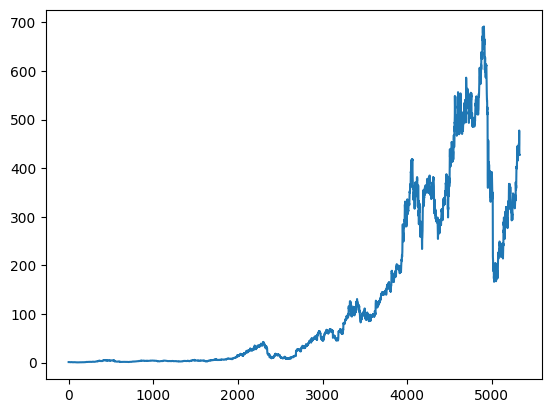

In [6]:
plt.plot(df1)

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.00119131],
       [0.00121094],
       [0.00113448],
       ...,
       [0.61784544],
       [0.6191039 ],
       [0.61813476]])

### Pre processing data

In [8]:
# Train and Test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size, test_size

(3463, 1866)

In [9]:
# Convert array of elements to dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3362, 100), (3362,), (1765, 100), (1765,))

In [11]:
# Reshape input to 3D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Creating LSTM model

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 50, batch_size=64, verbose=1)


Epoch 1/50
53/53 [==============================] - 15s 177ms/step - loss: 1.8506e-04 - val_loss: 0.0027
Epoch 2/50
53/53 [==============================] - 8s 158ms/step - loss: 2.3161e-05 - val_loss: 0.0048
Epoch 3/50
53/53 [==============================] - 8s 160ms/step - loss: 2.1956e-05 - val_loss: 0.0037
Epoch 4/50
53/53 [==============================] - 9s 161ms/step - loss: 2.2746e-05 - val_loss: 0.0026
Epoch 5/50
53/53 [==============================] - 9s 161ms/step - loss: 2.0943e-05 - val_loss: 0.0043
Epoch 6/50
53/53 [==============================] - 8s 159ms/step - loss: 1.9253e-05 - val_loss: 0.0046
Epoch 7/50
53/53 [==============================] - 8s 159ms/step - loss: 1.7162e-05 - val_loss: 0.0051
Epoch 8/50
53/53 [==============================] - 8s 161ms/step - loss: 1.7793e-05 - val_loss: 0.0024
Epoch 9/50
53/53 [==============================] - 8s 158ms/step - loss: 1.6036e-05 - val_loss: 0.0034
Epoch 10/50
53/53 [==============================] - 9s 161ms/s

### Predicting test data and plotting output

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

56/56 [==============================] - 1s 26ms/step


In [16]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [17]:
# Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

35.51285756442437

In [18]:
# Test data RMSE 
math.sqrt(mean_squared_error(y_test, test_predict))

345.40526963257173

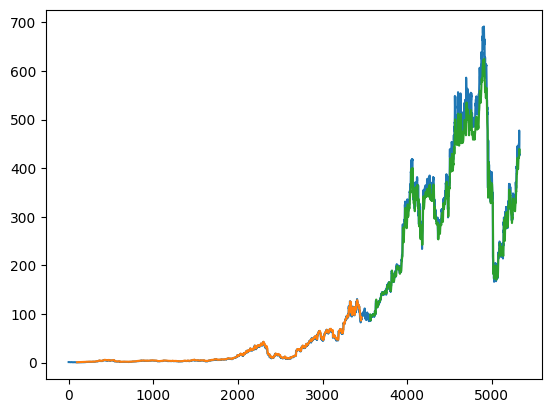

In [19]:
# Shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Predicting next 30 days and plotting output

In [20]:
X_input = test_data[1766:].reshape(1,-1)
X_input.shape

(1, 100)

In [21]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [22]:
# Prediciton for next 30 days
lst_output = []
n_steps = 100
i=0
while (i<30):
    if (len(temp_input)>100):
        X_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        X_input = X_input.reshape((1, n_steps, 1))
        yhat = model.predict(X_input, verbose = 0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i+=1
    else:
        X_input = X_input.reshape((1,n_steps,1))
        yhat = model.predict(X_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i+=1

print(lst_output)

[0.59496707]
101
1 day input [0.45537296 0.45081645 0.44566686 0.4504693  0.43020363 0.42294214
 0.42402703 0.42609553 0.43889719 0.44796682 0.43847769 0.44083551
 0.44179022 0.42459114 0.46288037 0.47448145 0.47342547 0.46743688
 0.47974673 0.48900441 0.49920237 0.50325259 0.50103942 0.49467477
 0.49030627 0.48981446 0.48868618 0.47830022 0.50022938 0.48929374
 0.48074483 0.48216243 0.46685829 0.47008403 0.47388837 0.47539271
 0.46603376 0.46400865 0.47080729 0.47670905 0.4683048  0.45880119
 0.46133259 0.46347345 0.46633756 0.47856058 0.47990587 0.48465044
 0.49816087 0.49111636 0.4853303  0.48223474 0.49121758 0.53653689
 0.52795903 0.52455976 0.5144052  0.52722134 0.51875922 0.54751593
 0.56791179 0.57116644 0.58259389 0.57874616 0.58318697 0.57703929
 0.57773358 0.59162013 0.60702549 0.61273924 0.62975026 0.63717084
 0.64354998 0.62429688 0.62826036 0.61343359 0.61058395 0.61281155
 0.60112374 0.60277274 0.62123027 0.61891584 0.63663564 0.63800985
 0.64446129 0.6342489  0.63317849

In [23]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [24]:
df3 = df1.tolist()
df3.extend(lst_output)

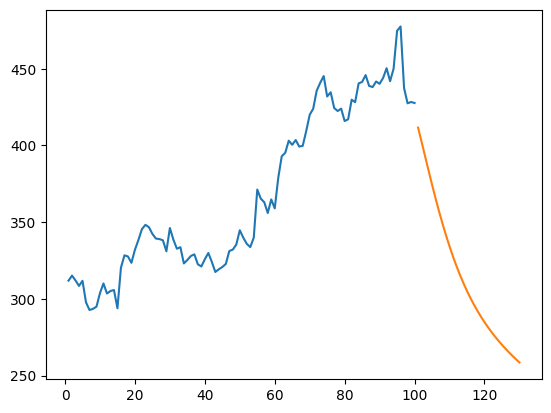

In [25]:
plt.plot(day_new, scaler.inverse_transform(df1[5229:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

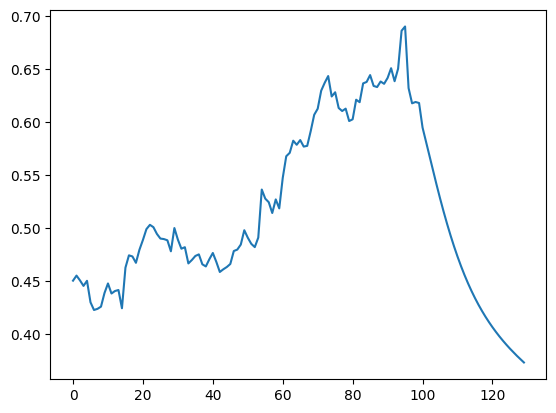

In [26]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[5229:])

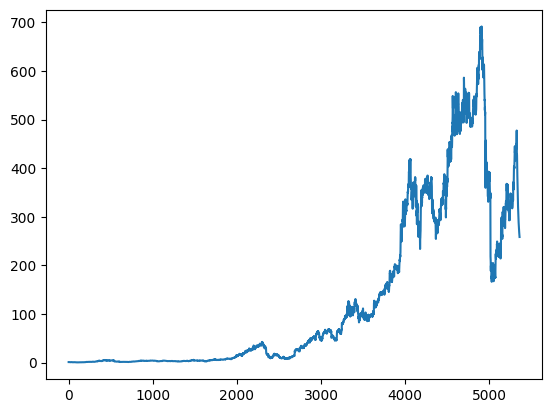

In [27]:
df3 = scaler.inverse_transform(df3).tolist()
plt.plot(df3)